In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import autograd
from autograd import grad, elementwise_grad
import autograd.numpy as np
#import autograd.scipy.stats.norm as norm
#from autograd.scipy.special import erf
from autograd.scipy.special import expit as sigmoid
from autograd.numpy.linalg import solve, cholesky
from autograd.misc.optimizers import adam
from autograd.misc.flatten import flatten_func

In [3]:
%load_ext autoreload
%autoreload
import sys
from Jordi.LFM_touch import LFM

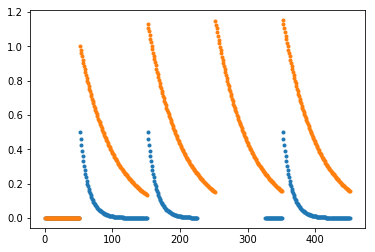

In [4]:
np.random.seed(42)

T=450
latentf = np.zeros([T,1])
latentf[[50,150,250,350]] = 1

def multi_y_same_LF(y0 = 1, D = 1, S = 1, LF = np.nan, stepsize = 1e-3, N=int(1e2)):
    ylist = []
    y_t = y0
    ylist.append(y_t)
    for n in range(N):
        dy = - D*y_t + S*LF[n]
        y_t = y_t + stepsize*dy
        ylist.append(y_t)
    return np.array(ylist)

y0=np.array([0,0]).reshape([2,1])
Decay = np.array([0.08,0.02]).reshape([2,1])
Coupling = np.array([0.5,1.]).reshape([2,1])
ysim = multi_y_same_LF(y0=y0, D = Decay, S = Coupling, LF=latentf, stepsize=1, N=latentf.shape[0])
ysim = ysim.reshape(-1,2)
y1,y2 = ysim[:,0].reshape([-1,1]), ysim[:,1].reshape([-1,1])
t1,t2 = np.array(range(1,T+2)).reshape([-1,1]),np.array(range(1,T+2)).reshape([-1,1])

#cut hole
cut=100
t1 = np.concatenate([t1[0: int(len(t1)/2)], t1[int(len(t1)/2)+cut:]])
y1 = np.concatenate([y1[0: int(len(y1)/2)], y1[int(len(y1)/2)+cut:]])

#random pick
#m=300
#r1=np.random.choice(len(t1),size=[m,1],replace=False).ravel(); r2=np.random.choice(len(t2),size=[m,1],replace=False).ravel()
#t1=t1[r1];t2=t2[r2];y1=y1[r1];y2=y2[r2];

#plot
plt.plot(t1,y1,'.',alpha=1)
plt.plot(t2,y2,'.',alpha=1)

In [5]:
%%time
p = 2
nlf = 1
initlogparams = {
        'lengthscales':[np.log(0.1)],
        'decays':[np.log(0.01)] * p,
        'sigmas':[np.log(0.001)] * p,
        'couplings':[[np.log(1)] * p] * nlf
}
fixparams = {k: False for k in initlogparams.keys()}
#fixparams['lengthscales'] = True
#fixparams['decays'] = True
#fixparams['sigmas'] = True
#fixparams['couplings'] = True

lfm = LFM(p=p, nlf=nlf, init_logparams=initlogparams)
lfm.fixparams = fixparams

t_train = np.arange(len(y1))
# Optimize
lfm.fit([t1,t2], [y1,y2], n_iter=10, n_update=1, lr=0.01)
#params = lfm.get_params()
#print('Decays', 1/params['decays'])

/home/daniel/.conda/envs/samplecause37/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/home/daniel/.conda/envs/samplecause37/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/home/daniel/.conda/envs/samplecause37/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated

Iteration 1. Current params:
   lengthscales : [array(0.09900498)]
   decays : [array(0.0101005), array(0.0099005)]
   sigmas : [array(0.00101005), array(0.00101005)]
   couplings : [[array(0.99004983), array(1.01005017)]]
  nll:  [13663.27620093] 

Iteration 2. Current params:
   lengthscales : [array(0.09801987)]
   decays : [array(0.01020201), array(0.00980199)]
   sigmas : [array(0.0010202), array(0.0010202)]
   couplings : [[array(0.98019867), array(1.02020134)]]
  nll:  [12805.91226698] 

Iteration 3. Current params:
   lengthscales : [array(0.09704455)]
   decays : [array(0.01030455), array(0.00970446)]
   sigmas : [array(0.00103045), array(0.00103045)]
   couplings : [[array(0.97044553), array(1.03045453)]]
  nll:  [11963.19277286] 

Iteration 4. Current params:
   lengthscales : [array(0.09607894)]
   decays : [array(0.01040811), array(0.00960789)]
   sigmas : [array(0.00104081), array(0.00104081)]
   couplings : [[array(0.96078944), array(1.04081077)]]
  nll:  [11140.60640394

In [6]:
%%time
lfm.fit([t1,t2], [y1,y2], n_iter=400, n_update=50, lr=0.01)

Iteration 50. Current params:
   lengthscales : [array(0.09254441)]
   decays : [array(0.01504852), array(0.00674758)]
   sigmas : [array(0.00146624), array(0.00138211)]
   couplings : [[array(0.65618096), array(1.51379948)]]
  nll:  [-224.13394649] 

Iteration 100. Current params:
   lengthscales : [array(0.05572238)]
   decays : [array(0.02160358), array(0.0051848)]
   sigmas : [array(0.00143508), array(0.00102302)]
   couplings : [[array(0.50190274), array(1.23486503)]]
  nll:  [-652.86528192] 

Iteration 150. Current params:
   lengthscales : [array(0.03422675)]
   decays : [array(0.03579467), array(0.00800278)]
   sigmas : [array(0.00085064), array(0.00059816)]
   couplings : [[array(0.31997432), array(0.7445505)]]
  nll:  [-1054.70890444] 

Iteration 200. Current params:
   lengthscales : [array(0.02259078)]
   decays : [array(0.05834817), array(0.01358253)]
   sigmas : [array(0.00049039), array(0.00035271)]
   couplings : [[array(0.23037013), array(0.48635305)]]
  nll:  [-1362.3

[('lengthscales', array([0.02293616])), ('decays', array([0.08305946, 0.02016192])), ('sigmas', array([6.49196964e-05, 4.72357053e-05])), ('couplings', array([[0.24025803, 0.46574517]]))]
[('lengthscales', array([0.02293616])), ('decays', array([0.08305946, 0.02016192])), ('sigmas', array([6.49196964e-05, 4.72357053e-05])), ('couplings', array([[0.24025803, 0.46574517]]))]


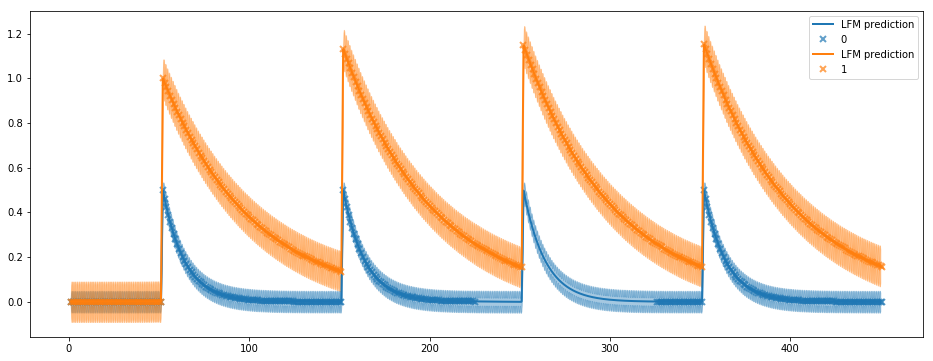

In [7]:
#### Generate test data
t=np.arange(1,450,0.2)
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=[16,6])
for sat in range(2):
    pred,pred_v,k,pred_lf,pred_lf_v,k_lf = lfm.predict(t, [t1,t2], [y1,y2], whichp=sat, latent=True, retPV=True)
    ax.plot(t, pred , '-',color='C'+str(sat),lw=2,label='LFM prediction')
    plt.fill_between(
        t,
        (pred - 2 * np.sqrt(pred_v))[:, 0],
        (pred + 2 * np.sqrt(pred_v))[:, 0],color='C'+str(sat),alpha=0.4)
    ax.plot([t1,t2][sat],[y1,y2][sat],'x',alpha=0.7,color='C'+str(sat),label=sat,mew=2)
    ax.legend()

[('lengthscales', array([0.02293616])), ('decays', array([0.08305946, 0.02016192])), ('sigmas', array([6.49196964e-05, 4.72357053e-05])), ('couplings', array([[0.24025803, 0.46574517]]))]
[('lengthscales', array([0.02293616])), ('decays', array([0.08305946, 0.02016192])), ('sigmas', array([6.49196964e-05, 4.72357053e-05])), ('couplings', array([[0.24025803, 0.46574517]]))]


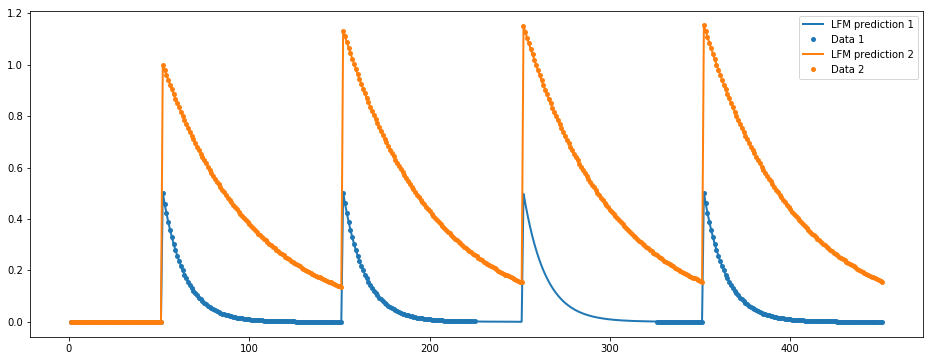

In [8]:
#### Generate test data
t=np.arange(1,450,0.2)
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=[16,6])
for sat in range(2):
    pred,pred_v,k,pred_lf,pred_lf_v,k_lf = lfm.predict(t, [t1,t2], [y1,y2], whichp=sat, latent=True, retPV=True)
    ax.plot(t, pred , '-',color='C'+str(sat),lw=2,label='LFM prediction '+str(sat+1))
    #plt.fill_between(
    #    t,
    #    (pred - 2 * np.sqrt(pred_v))[:, 0],
    #    (pred + 2 * np.sqrt(pred_v))[:, 0],color='C'+str(sat),alpha=0.4)
    ax.plot([t1,t2][sat],[y1,y2][sat],'.',alpha=0.99,color='C'+str(sat),label='Data '+str(sat+1),mew=2)
    ax.legend()

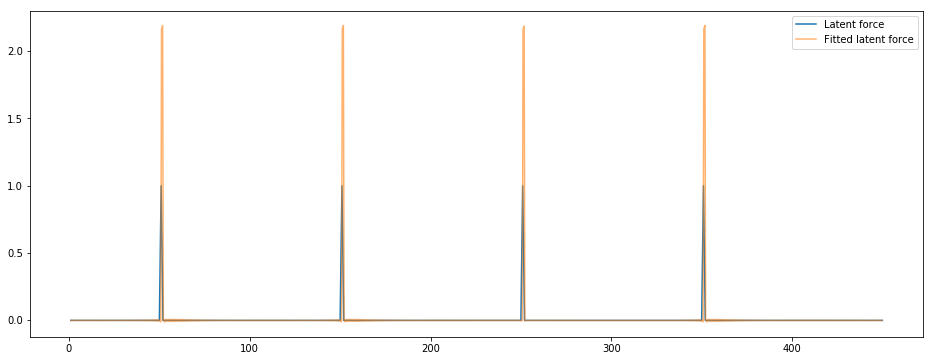

In [9]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=[16,6])
ax.plot(range(1,len(latentf)+1),latentf,label='Latent force')
ax.plot(t,pred_lf,'-',alpha=0.6,label='Fitted latent force')
ax.legend()

# GPflow

In [10]:
import gpflow
import tensorflow as tf
from gpflow.ci_utils import ci_niter

In [11]:
# Augment the input with ones or zeros to indicate the required output dimension (pretty lame implementation)
t_augmented = 1.0*np.vstack((np.hstack((t1, np.zeros_like(t1))), np.hstack((t2, np.ones_like(t2)))))

# Augment the Y data with ones or zeros that specify a likelihood from the list of likelihoods
y_augmented = np.vstack((np.hstack((y1, np.zeros_like(y1))), np.hstack((y2, np.ones_like(y2)))))

In [12]:
output_dim = 2  # Number of outputs
rank = 1  # Rank of W

# Base kernel
#k = gpflow.kernels.Matern32(active_dims=[0]) + gpflow.kernels.White(active_dims=[0])
#k = gpflow.kernels.Matern12(active_dims=[0]) + gpflow.kernels.White(active_dims=[0])  # Best exrtapolation
#k = gpflow.kernels.White(active_dims=[0]) + gpflow.kernels.RBF(active_dims=[0]) # interestingly enough fails miserably
k = gpflow.kernels.Matern12(active_dims=[0]) +gpflow.kernels.White(active_dims=[0])

# Coregion kernel
coreg = gpflow.kernels.Coregion(output_dim=output_dim, rank=rank, active_dims=[1])

kern = k * coreg

In [13]:
# This likelihood switches between Gaussian noise with different variances for each f_i:
lik = gpflow.likelihoods.SwitchedLikelihood(
    [gpflow.likelihoods.Gaussian(), gpflow.likelihoods.Gaussian()]
)

# now build the GP model as normal
#m2 = gpflow.models.VGP((t_augmented, y_augmented), kernel=kern, likelihood=lik)
m2 = gpflow.models.GPR((t_augmented, y_augmented), kernel=kern)

# fit the covariance function parameters
maxiter = ci_niter(10)
gpflow.optimizers.Scipy().minimize(
    m2.training_loss, m2.trainable_variables, options=dict(maxiter=maxiter), method="L-BFGS-B",
)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


      fun: -2256.029164286021
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.04099802e+01,  3.47391834e+02,  6.43211353e-04, -1.66698354e+02,
        8.80067440e+01,  8.49388070e+01,  2.54835014e-02,  4.51682836e+00])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 19
      nit: 10
     njev: 19
   status: 1
  success: False
        x: array([ 2.29404609e+01, -4.11010746e+00, -2.06466357e+01,  1.55308861e-02,
        2.28068410e+00,  2.70714702e+00, -6.64124152e+00, -1.05523712e+01])

In [14]:
%%time
maxiter = ci_niter(1000)
gpflow.optimizers.Scipy().minimize(
    m2.training_loss, m2.trainable_variables, options=dict(maxiter=maxiter), method="L-BFGS-B",
)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 46.4 s, sys: 7.68 s, total: 54.1 s
Wall time: 9.38 s


      fun: -3917.129795160925
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.45625861e-006,  1.47528645e-002,  6.46015159e-268,
        4.92647197e-005, -4.20883828e-005,  1.63345444e-005,
        1.05749046e-008,  0.00000000e+000])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 65
      nit: 59
     njev: 65
   status: 0
  success: True
        x: array([ 6.21670845e+03, -9.78768574e+00, -6.44067543e+02,  2.50045108e+02,
        4.97551134e+02,  1.16713729e+03, -5.94741322e+00, -4.43765156e+03])

In [15]:
m2

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].kernels[0].variance,Parameter,Softplus,,True,(),float64,5.6137090696716706e-05
GPR.kernel.kernels[0].kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,6216.708454658746
GPR.kernel.kernels[0].kernels[1].variance,Parameter,Softplus,,True,(),float64,1.9276146397358871e-280
GPR.kernel.kernels[1].W,Parameter,Identity,,True,"(2, 1)",float64,[[250.04510819] [497.55113399]]
GPR.kernel.kernels[1].kappa,Parameter,Softplus,,True,"(2,)",float64,[1.16713729e+03 2.60918310e-03]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1e-06


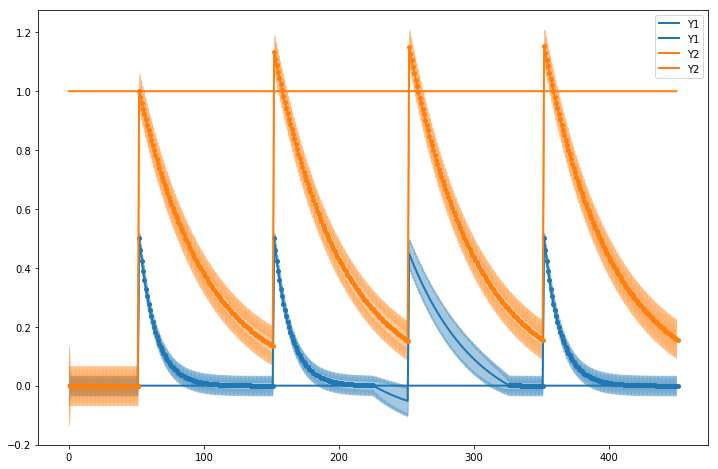

In [16]:
def plot_gp(x, mu, var, color, label):
    plt.plot(x, mu, color=color, lw=2, label=label)
    plt.fill_between(
        x[:, 0],
        (mu - 2 * np.sqrt(var))[:, 0],
        (mu + 2 * np.sqrt(var))[:, 0],
        color=color,
        alpha=0.4,
    )


def plot(m):
    plt.figure(figsize=(12, 8))
    Xtest = np.linspace(0, 450, 4500)[:, None]
    (line,) = plt.plot(t1, y1, ".", mew=2)
    mu, var = m.predict_f(np.hstack((Xtest, np.zeros_like(Xtest))))
    plot_gp(Xtest, mu, var, line.get_color(), "Y1")

    (line,) = plt.plot(t2, y2, ".", mew=2)
    mu, var = m.predict_f(np.hstack((Xtest, np.ones_like(Xtest))))
    plot_gp(Xtest, mu, var, line.get_color(), "Y2")

    plt.legend()


plot(m2)

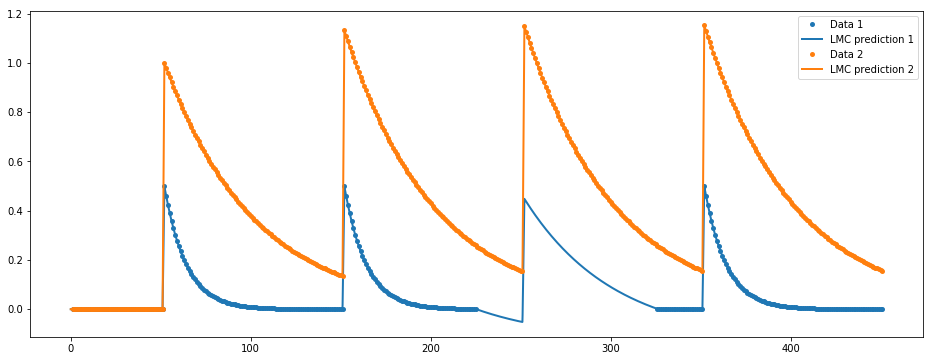

In [17]:
plt.figure(figsize=(16, 6))
Xtest = np.linspace(0, 450, 4500)[:, None]
(line,) = plt.plot(t1, y1, ".", mew=2,color='C0',label='Data 1')
mu, var = m2.predict_f(np.hstack((Xtest, np.zeros_like(Xtest))))
plt.plot(Xtest, mu[:,0], color='C0', lw=2, label='LMC prediction 1')

(line,) = plt.plot(t2, y2, ".", mew=2,color='C1',label='Data 2')
mu, var = m2.predict_f(np.hstack((Xtest, np.ones_like(Xtest))))
plt.plot(Xtest, mu[:,0], color='C1', lw=2, label='LMC prediction 2')

plt.legend()